In [1]:
import os
import random
import time
import datetime
import pickle
import sqlite3
import re

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
# path on rte
db_path = "/home/rte/data/db/arxiv_db_images.sqlite3"

# Here we import the sqlite3 database and create a cursor
db = sqlite3.connect(db_path)
c = db.cursor()

In [4]:
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

Using TensorFlow backend.


In [5]:
# this seems to help with some GPU memory issues

# import tensorflow as tf

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
print("model loaded")
model.summary()

# set up the feature extractor

feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
print("feature extractor setup")
feat_extractor.summary()

W0520 15:02:04.792203 139762958726976 deprecation_wrapper.py:119] From /home/rte/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0520 15:02:04.795153 139762958726976 deprecation_wrapper.py:119] From /home/rte/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0520 15:02:04.800996 139762958726976 deprecation_wrapper.py:119] From /home/rte/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0520 15:02:04.832133 139762958726976 deprecation_wrapper.py:119] From /home/rte/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0520 15:02:05.890519 139762958

model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0       

In [7]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
# Get all images from cs.AI from 2012 (whole year)

name = "csAI_all2012"

sql = ("SELECT metadata.cat, images.path, images.filename, images.identifier, metadata.created, images.id, metadata.id "
    "FROM images "
    "LEFT JOIN metadata ON images.identifier = metadata.identifier "
    "WHERE images.x != '' "
    "AND metadata.created BETWEEN date('2012-01-01') "
    "AND date('2012-12-31') "
    "AND substr(trim(metadata.cat),1,instr(trim(metadata.cat)||' ',' ')-1) = ?")

c.execute(sql, ("cs.AI", ))
rows = c.fetchall()
print(len(rows))

In [8]:
# Get images from stat.ML from 2012 (whole year)

name = "statML_all2012"

sql = ("SELECT metadata.cat, images.path, images.filename, images.identifier, metadata.created, images.id, metadata.id "
    "FROM images "
    "LEFT JOIN metadata ON images.identifier = metadata.identifier "
    "WHERE images.x != '' "
    "AND metadata.created BETWEEN date('2012-01-01') "
    "AND date('2012-12-31') "
    "AND substr(trim(metadata.cat),1,instr(trim(metadata.cat)||' ',' ')-1) = ? ")

c.execute(sql, ("stat.ML", ))
rows = c.fetchall()
print(len(rows))

2889


In [9]:
paths = []
all_images_path = "/mnt/hd2/images/all/"
for row in rows:
    paths.append(all_images_path + str(row[5]) + ".jpg")
print(paths[:3])
print(len(paths))

['/mnt/hd2/images/all/9052555.jpg', '/mnt/hd2/images/all/9052556.jpg', '/mnt/hd2/images/all/9052557.jpg']
2889


In [10]:
# run the classifier over all images

# images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(current_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
num_x = len(paths)
# print("keeping %d images to analyze" % num_x)

tic = time.clock()

features = []
for i, image_path in enumerate(paths):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(paths),elap))
        tic = time.clock()
    img, x = load_image(image_path)

    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(paths))

# write images, features to a pickle file

pickle_file = "features_" + name + "_vgg_x" + str(num_x) + ".pickle"

print(pickle_file)

# WRITE
with open(pickle_file, "wb") as write_file:
    pickle.dump([paths, features], write_file)
    write_file.close()

analyzing image 0 / 2889. Time: 0.0003 seconds.
analyzing image 500 / 2889. Time: 11.0755 seconds.
analyzing image 1000 / 2889. Time: 11.0459 seconds.
analyzing image 1500 / 2889. Time: 10.1366 seconds.
analyzing image 2000 / 2889. Time: 10.4124 seconds.
analyzing image 2500 / 2889. Time: 11.3558 seconds.
finished extracting features for 2889 images
features_statML_all2012_vgg_x2889.pickle


In [ ]:
pickle_file = "features_" + name + "_vgg_x" + str(num_x) + ".pickle"

In [11]:
perp = 50
bPCA = True
num_iterations = 2000

----- checking images and features -----
length of images: 2889
length of features: 2889
image: /mnt/hd2/images/all/9052555.jpg, features: 0.00,1.95,0.00,0.75... 
image: /mnt/hd2/images/all/9052556.jpg, features: 0.00,2.22,1.47,0.47... 
image: /mnt/hd2/images/all/9052557.jpg, features: 1.38,0.00,0.00,3.03... 
image: /mnt/hd2/images/all/9052558.jpg, features: 0.00,6.46,0.00,0.24... 
image: /mnt/hd2/images/all/9052559.jpg, features: 0.00,2.65,0.00,0.53... 
----- running pca across features -----
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2889 samples in 0.032s...
[t-SNE] Computed neighbors for 2889 samples in 3.844s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2889
[t-SNE] Computed conditional probabilities for sample 2000 / 2889
[t-SNE] Computed conditional probabilities for sample 2889 / 2889
[t-SNE] Mean sigma: 15.093056
[t-SNE] Computed conditional probabilities in 0.216s
[t-SNE] Iteration 50: error = 75.7213974, gradient norm = 0.0000042 (50 iterat

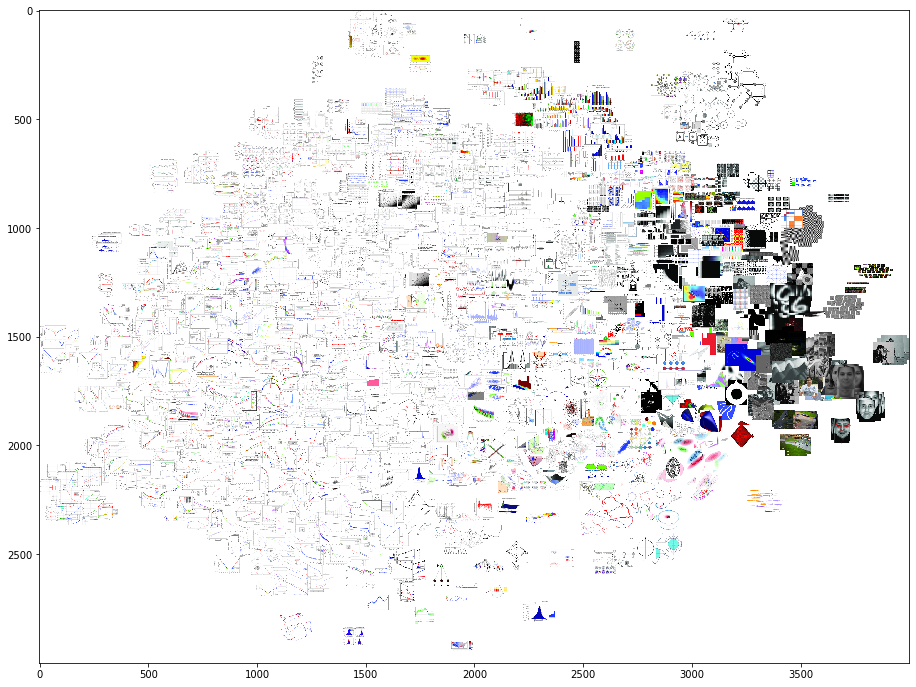

In [12]:
with open(pickle_file, "rb") as read_file:
    images, features = pickle.load(read_file)
    read_file.close()

# check that we still have the features and list of images
print("----- checking images and features -----")
print("length of images: " + str(len(images)))
print("length of features: " + str(len(features)))
for img, f in list(zip(images, features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

if len(images) >= 300:
    features = np.array(features)
    print("----- running pca across features -----")
    pca = PCA(n_components=300)
    pca.fit(features)

    pca_features = pca.transform(features)

    X = np.array(pca_features)
    X.shape
    tsne = TSNE(n_components=2, learning_rate=150, perplexity=perp, angle=0.2, verbose=2, n_iter=num_iterations).fit_transform(X)

    # normalise points
    tx, ty = tsne[:,0], tsne[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

    width = 4000
    height = 3000
    max_dim = 100

    full_image = Image.new('RGBA', (width, height))
    for img, x, y in zip(images, tx, ty):
        tile = Image.open(img)
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

    plt.figure(figsize = (16,12))
    imshow(full_image)

    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H-%M-%S')
    filename = "tSNE_" + name + "_x" + str(len(images)) + "_n" + str(num_iterations) + "_p" + str(perp) + "_" + st
    print(filename)
    full_image.save(filename + ".png")


In [13]:
# go through all of the retrieved SQL rows and format as an accreditation
# if html is True, format with <a href=####> for web usage
# input = [[author, title, date, identifier], [author, title, date, identifier],...[author, title, date, identifier]]

def format_credits(rows, html=False):
    accreditations = []

    empty_counter = 0
    
    # grab the details and check each
    for i, row in enumerate(rows):
        print(i)
        if row:
            s = row[0]
            start = "['"
            end = "']"
            author = s[s.find(start)+len(start):s.rfind(end)]
            author = author[:-2]
            print(author)

            title = row[1]
            # replace line breaks and double spaces
            title = title.replace("\n", "").replace("  "," ")
            print(title)

            date = row[2].split("-")[0]
            print(date)

            identifier = row[3]
            print(identifier)
        #     reg_exp = re.compile("/[^\d]\d{2}[^\d]/")
            longest_digits = max(re.findall(r'\d+', identifier), key = len)
            print(len(longest_digits))

            # if the identifier contains seven consecutive numbers, add a slash
            if len(longest_digits) == 7:
                print("----- regex match -----")
                reverse = identifier[::-1]
                print(reverse)
                identifier_reverse = reverse[:7] + "/" + reverse[7:]
                identifier = identifier_reverse[::-1]
            else:
                # otherwise we can leave the identifier how it is
                print("----- no match -----")
            print(identifier)
            url = "https://arxiv.org/abs/" + identifier
            print(url)
            print("*" * 20)

            # format string and append
            if html:
                fmt_str = '{}: {}, {}, <a href="{}">{}</a>'
                accreditations.append(fmt_str.format(author, title, str(date), url, url))  
            else:
                fmt_str = '{}: {}, {}, {}'
                accreditations.append(fmt_str.format(author, title, str(date), url, url))
        else:
            empty_counter += 1
            print("empty!")

    print("number of empty slots:", empty_counter)
    return accreditations

In [14]:
meta_ids = []

for row in rows:
#     print(row[5])
#     ids.append(row[5])
    meta_ids.append(row[6])
#     path = row[1] + '/' + row[2]
#     print(path)
#     filepaths.append(path)
print("meta_ids length:",len(meta_ids))

meta_ids length: 2889


In [15]:
def unique(ilist):
    ulist = []
    for x in ilist:
        if x not in ulist:
            ulist.append(x)
    return ulist

meta_ids = unique(meta_ids)
print(len(meta_ids))

237


In [16]:
rows = []

sql = ("SELECT metadata.authors, metadata.title, metadata.created, metadata.identifier "
    "FROM metadata "
    "WHERE metadata.id is ? ")

# iterate over the file_ids list and grab sql data
for file_id in meta_ids[:]:
    print("image parent article id:",file_id)
    c.execute(sql, (file_id, ))
    row = c.fetchall()
    rows.append(row[0])
    print(row[0])
#     print(len(row))
#     print(len(row[0]))
#     print(list(rows))

accreditations = format_credits(rows, False)

os.chdir("/home/rte/documentation/data-samples/")
print(os.getcwd())

f = open(filename + ".txt", "w+")
for row in accreditations:
    f.write(str(row) + "\n")
f.close()

image parent article id: 7448
("['Häusler, Chris; Susemihl, Alex; ']", 'Temporal Autoencoding Restricted Boltzmann Machine', '2012-10-31', '1210.8353')
image parent article id: 7760
("['Sun, Ju; Zhang, Yuqian; Wright, John; ']", 'Efficient Point-to-Subspace Query in $\\ell^1$: Theory and Applications\n  in Computer Vision', '2012-11-04', '1211.0757')
image parent article id: 7813
("['Montufar, Guido F.; Morton, Jason; ']", 'Kernels and Submodels of Deep Belief Networks', '2012-11-05', '1211.0932')
image parent article id: 39629
("['Khaleghi, Azadeh; Ryabko, Daniil; ']", 'Multiple Change Point Estimation in Stationary Ergodic Time Series', '2012-03-07', '1203.1515')
image parent article id: 48087
("['Lafferty, John; Liu, Han; Wasserman, Larry; ']", 'Sparse Nonparametric Graphical Models', '2012-01-03', '1201.0794')
image parent article id: 79772
("['Vats, Divyanshu; ']", 'High-Dimensional Screening Using Multiple Grouping of Variables', '2012-08-09', '1208.2043')
image parent article id

In [ ]:
# print out with line breaks
for a in unique:
    print(a)